# IBM Attrition Analysis and Prediction (needs to be optimized!)
Problem:
The HR team collected data to develop a model that could predict which employees are more likely to quit and leave the company. The Dataset is avaialbe at https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset.

## 1. Load libraries and read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

In [5]:
employee = pd.read_csv("Human_Resources.csv")
print(employee.shape)
employee.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 2. Visualizations

Let's replace 'Attrition', 'OverTime' and 'Over18' with integers before any visualizations.

In [6]:
employee.Attrition = np.where(employee.Attrition=='Yes',1,0) # faster than using apply
employee.Over18 = np.where(employee.Over18=='Y',1,0)
employee.OverTime = np.where(employee.OverTime=='Yes',1,0)

Check for any missing values.

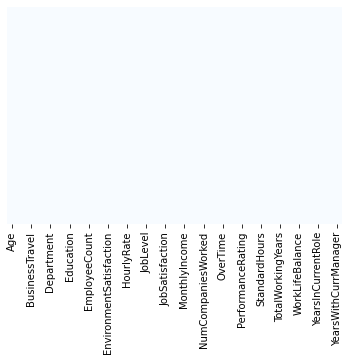

In [7]:
sns.heatmap(employee.isnull(), yticklabels=False, cbar=False, cmap='Blues');

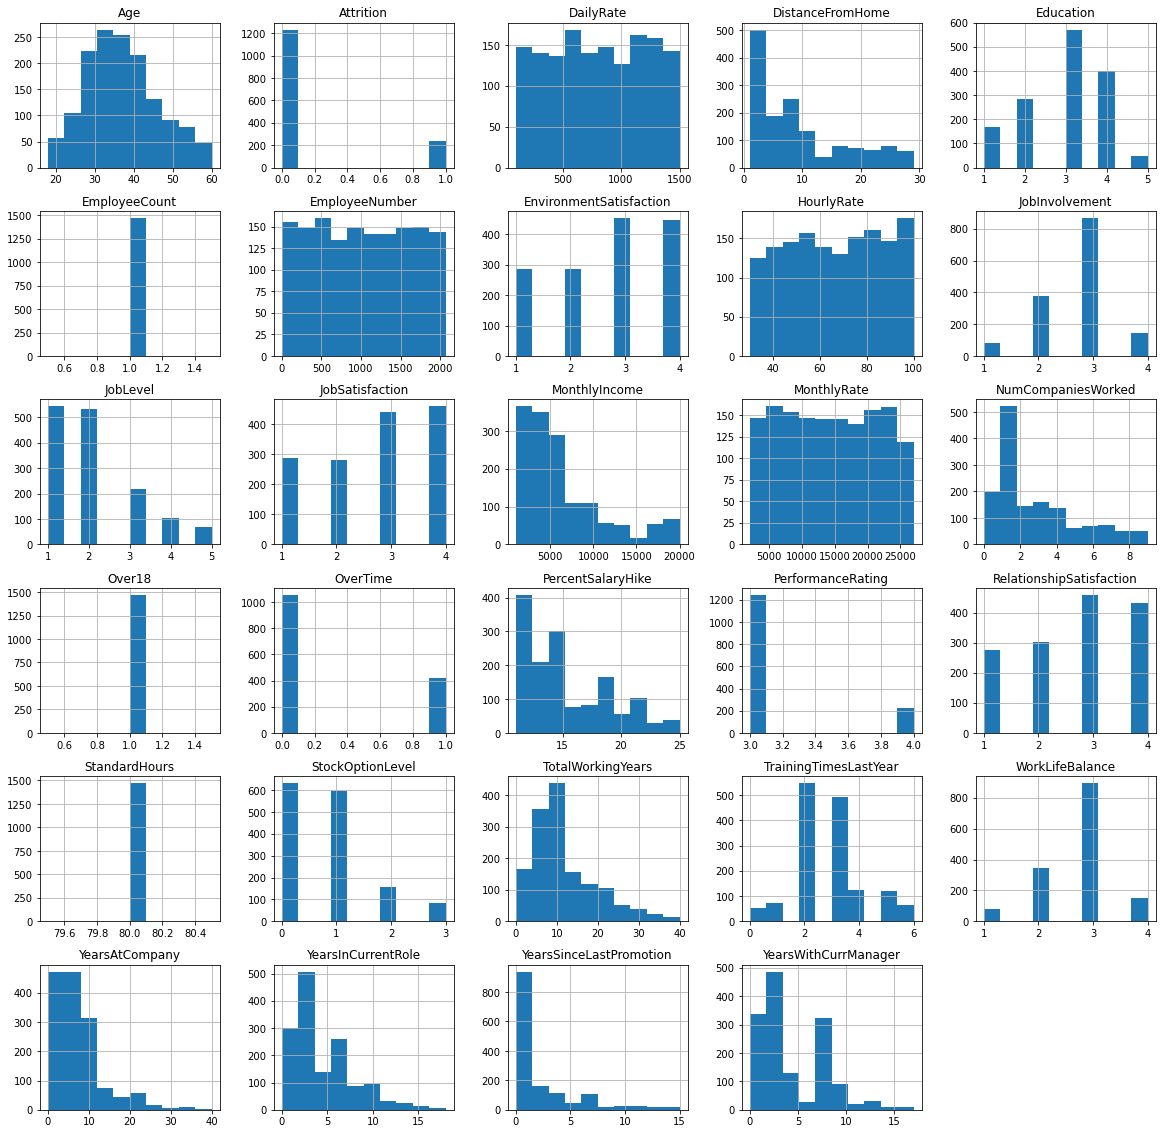

In [8]:
employee.hist(figsize=(20,20));

Drop 'EmployeeCount', 'StandardHours', 'Over18' since they do not change. 'EmployeeNumber' may also be dropped.

In [9]:
employee.drop(columns=['EmployeeCount','StandardHours','Over18','EmployeeNumber'],
             inplace=True)

Segment the dataframe into employees left and stayed. 
How many employees left and how many stayed in the company?

In [10]:
left_df = employee[employee.Attrition==1]
stayed_df = employee[employee.Attrition==0]
print("Left: {} ({:.2f}%), Stayed: {} ({:.2f}%)".format(len(left_df),
                                                       len(left_df)/len(employee)*100.0,
                                                       len(stayed_df),
                                                       len(stayed_df)/len(employee)*100.0))

Left: 237 (16.12%), Stayed: 1233 (83.88%)


Looking at the two new datasets we notice the following points right a way:
1. 'Age': Average age of the employees who left the company is lower than who stayed.
2. 'DailyRate': Rate of employees who stayed is higher.
3. 'DistanceFromHome': Employees who stayed live closer to the workplace.
4. 'EnvironmentSatisfaction' & 'JobSatisfaction' : Employees who stayed are generally more satisfied.
And many more that will be clear after illustrating the correlations.
    

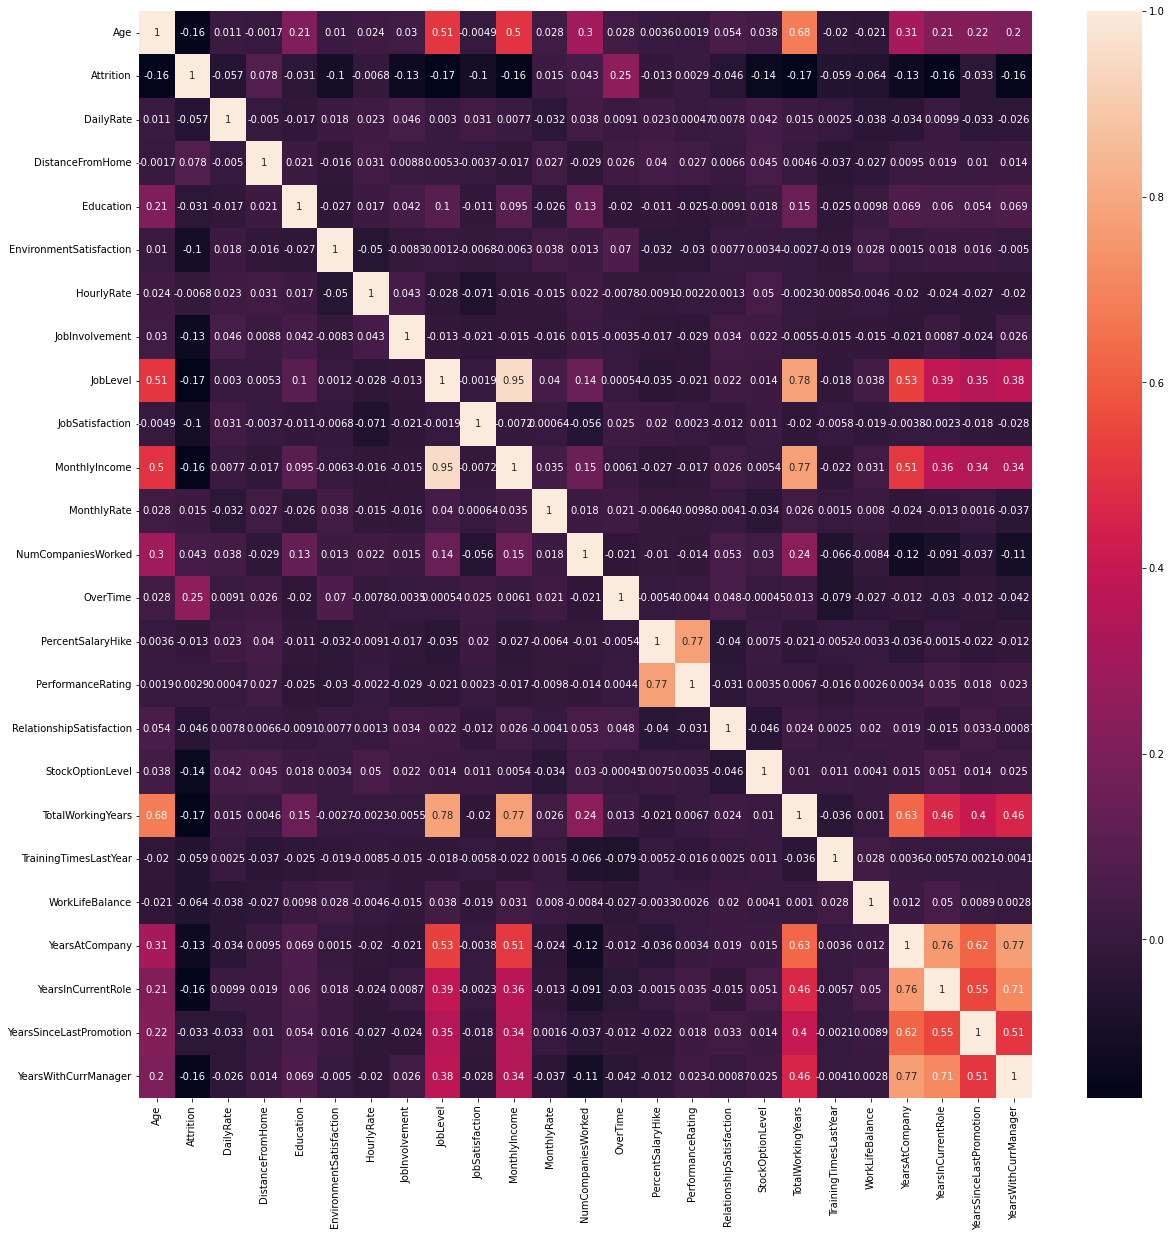

In [11]:
# Check correlations between different attributes of the data
correlations = employee.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlations, annot=True);

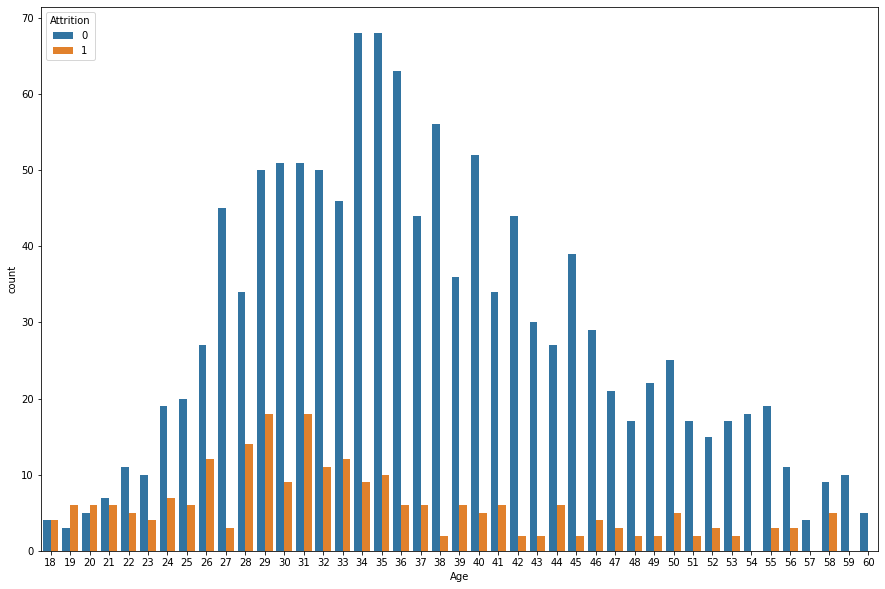

In [12]:
# To compare employee turnover w.r.t. 'Age'
plt.figure(figsize=(15,10))
sns.countplot(x='Age',hue='Attrition',data=employee);

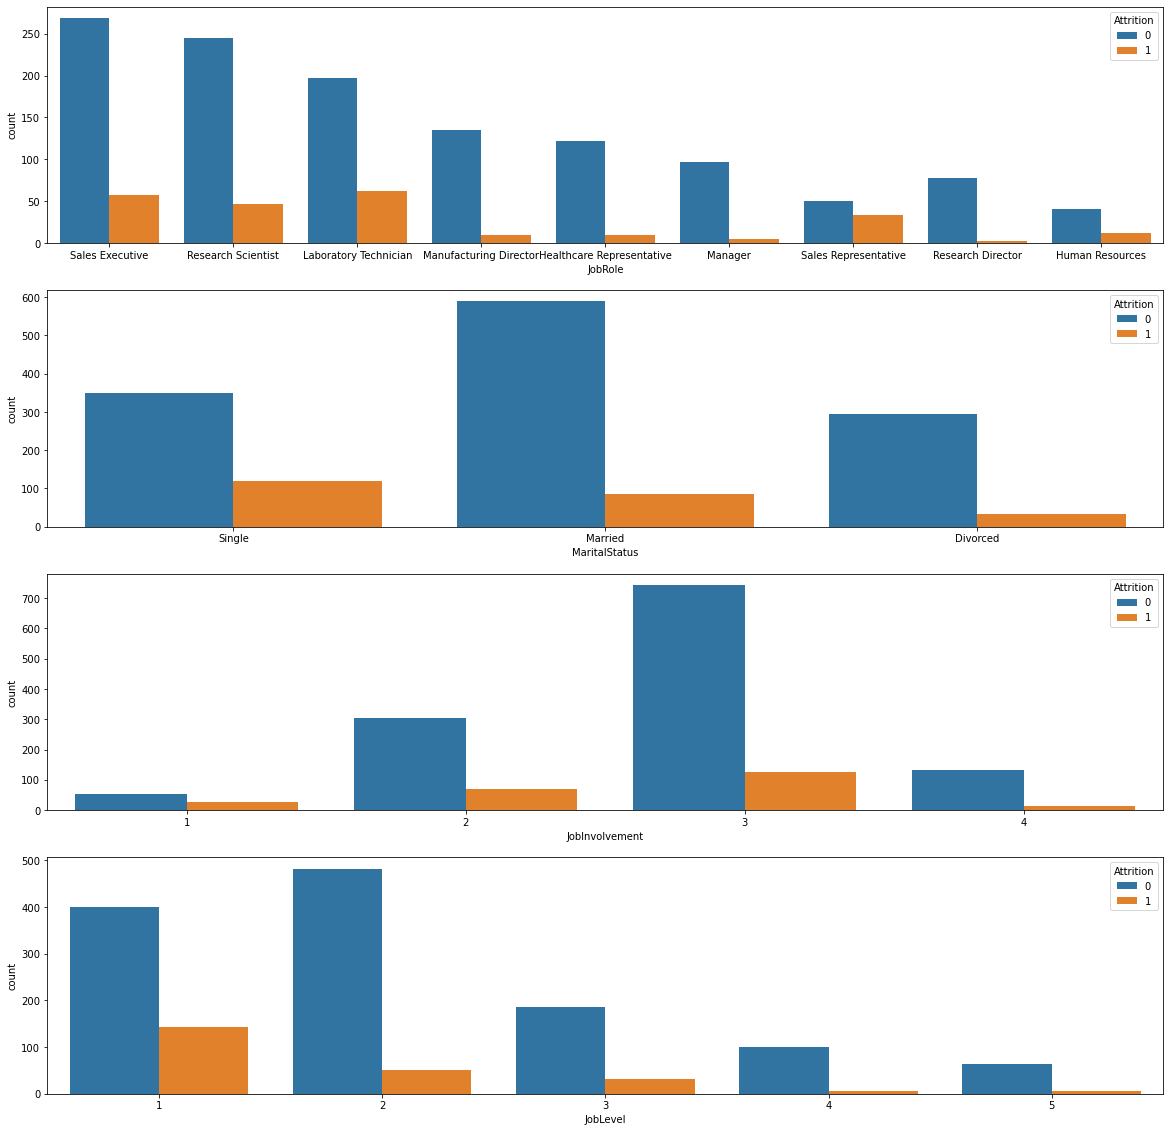

In [13]:
# To compare employee turnover w.r.t. 'JobRole', 'MaritalStatus', 'JobInvolvement' and 
# 'JobLevel'
plt.figure(figsize=(20,20))
plt.subplot(411)
sns.countplot(x='JobRole', hue='Attrition', data=employee)
plt.subplot(412)
sns.countplot(x='MaritalStatus', hue='Attrition', data=employee)
plt.subplot(413)
sns.countplot(x='JobInvolvement', hue='Attrition', data=employee)
plt.subplot(414)
sns.countplot(x='JobLevel', hue='Attrition', data=employee);

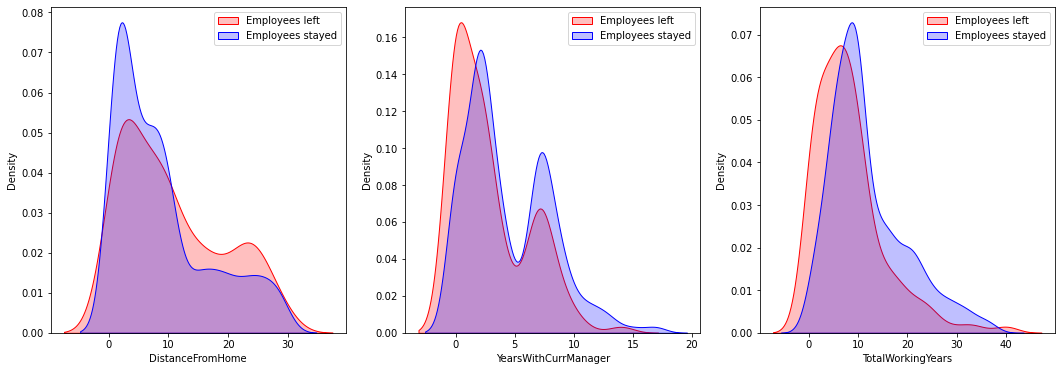

In [15]:
# Check the tendency of leaving using kde plots for 'DistanceFromHome', 
# 'YearsWithCurrManager' and 'TotalWorkingYears'
plt.figure(figsize=(18,6))
plt.subplot(131)
sns.kdeplot(x=left_df.DistanceFromHome,label='Employees left',shade=True, color='r')
sns.kdeplot(x=stayed_df.DistanceFromHome,label='Employees stayed',shade=True, color='b')
plt.legend()
plt.subplot(132)
sns.kdeplot(x=left_df.YearsWithCurrManager,label='Employees left',shade=True, color='r')
sns.kdeplot(x=stayed_df.YearsWithCurrManager,label='Employees stayed',shade=True, color='b')
plt.legend()
plt.subplot(133)
sns.kdeplot(x=left_df.TotalWorkingYears,label='Employees left',shade=True, color='r')
sns.kdeplot(x=stayed_df.TotalWorkingYears,label='Employees stayed',shade=True, color='b');
plt.legend();

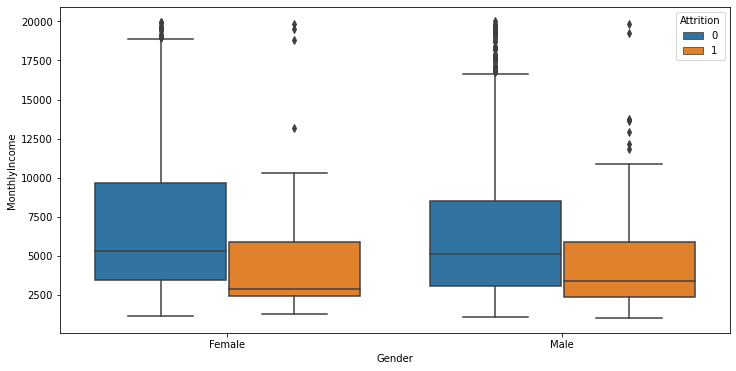

In [16]:
# Gender vs MonthlyIncome
plt.figure(figsize=(12,6))
sns.boxplot(x='Gender',y='MonthlyIncome',data=employee,hue='Attrition');

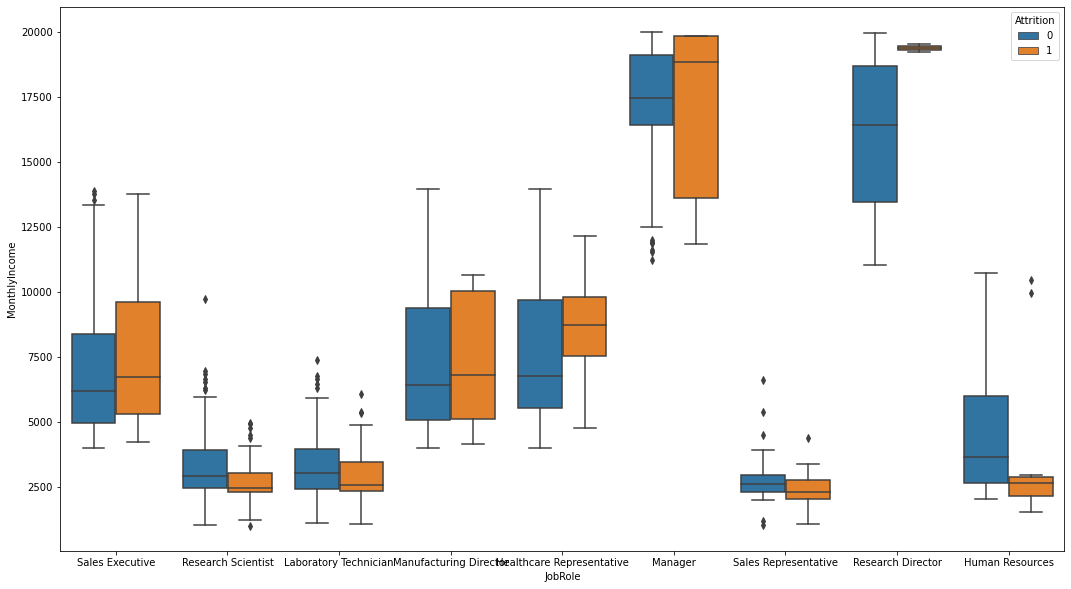

In [18]:
# JobRole vs MonthlyIncome
plt.figure(figsize=(18,10))
sns.boxplot(x='JobRole',y='MonthlyIncome',data=employee, hue='Attrition');

## 3. Preporcessing

In [35]:
# Segment dataframe to categorical and numerical and encode the categorical dataframe

cat_columns = employee.select_dtypes('object').columns.tolist() #categorical cols
num_columns = employee.columns.difference(cat_columns)  #numerical cols

X_cat = employee[cat_columns]
X_num = employee[num_columns].drop(["Attrition"],axis=1)   # Attrition is our target value

onehotencoder = OneHotEncoder()   # need to drop one column from each categorical to avoid
                                    # dummy variable trap which causes Multicollinearity
                                    # for linear models
X_cat = onehotencoder.fit_transform(X_cat).toarray()
X_cat = pd.DataFrame(X_cat)

X_all = pd.concat([X_num, X_cat],axis=1)

In [36]:
# Scaling the features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X_all)

In [37]:
# target value
y = employee.Attrition

In [38]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

## 4. Logistic Regression

Accuracy score, LR model: 89.67 % 



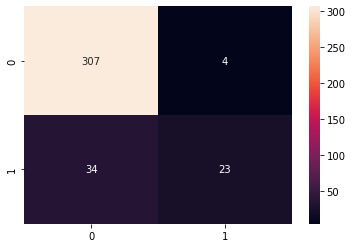

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       311
           1       0.85      0.40      0.55        57

    accuracy                           0.90       368
   macro avg       0.88      0.70      0.74       368
weighted avg       0.89      0.90      0.88       368



In [39]:
# Train logistic regression classifier
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy Score
print("Accuracy score, LR model: {:.2f} % \n".format(accuracy_score(y_test,y_pred)*100))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d');
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

## 5. Random Forest Classifier

Accuracy score, LR model: 86.41 % 



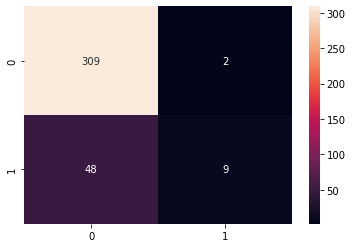

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       311
           1       0.82      0.16      0.26        57

    accuracy                           0.86       368
   macro avg       0.84      0.58      0.59       368
weighted avg       0.86      0.86      0.82       368



In [40]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# accuracy score
print("Accuracy score, LR model: {:.2f} % \n".format(accuracy_score(y_test,y_pred)*100))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

## 6. Artificial Neural Network

In [41]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=500, activation='relu', input_shape=(50,)))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

2022-02-13 14:59:15.422253: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 14:59:15.422649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 14:59:15.422965: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               25500     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 501       
Total params: 527,001
Trainable params: 527,001
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
epochs_hist = model.fit(X_train, y_train, epochs=100, batch_size=50)

2022-02-13 15:02:58.880522: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-13 15:02:58.900162: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1094400000 Hz


Epoch 1/10
23/23 [==============================] - 3s 31ms/step - loss: 0.4697 - accuracy: 0.8346
Epoch 2/10
23/23 [==============================] - 1s 29ms/step - loss: 0.3455 - accuracy: 0.8575
Epoch 3/10
23/23 [==============================] - 1s 29ms/step - loss: 0.3024 - accuracy: 0.8779
Epoch 4/10
23/23 [==============================] - 1s 29ms/step - loss: 0.2885 - accuracy: 0.8830
Epoch 5/10
23/23 [==============================] - 1s 28ms/step - loss: 0.2349 - accuracy: 0.9107
Epoch 6/10
23/23 [==============================] - 1s 28ms/step - loss: 0.2223 - accuracy: 0.9106
Epoch 7/10
23/23 [==============================] - 1s 28ms/step - loss: 0.1888 - accuracy: 0.9349
Epoch 8/10
23/23 [==============================] - 1s 31ms/step - loss: 0.2259 - accuracy: 0.9097
Epoch 9/10
23/23 [==============================] - 1s 33ms/step - loss: 0.1619 - accuracy: 0.9213
Epoch 10/10
23/23 [==============================] - 1s 32ms/step - loss: 0.1548 - accuracy: 0.9485


In [25]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

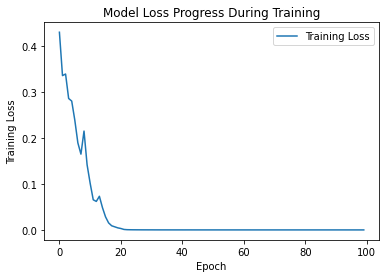

In [38]:
# plot the epochs history
plt.plot(epochs_hist.history['loss'],label='Training Loss')
plt.gca().set(title='Model Loss Progress During Training',
             xlabel='Epoch',
             ylabel='Training Loss')
plt.legend();

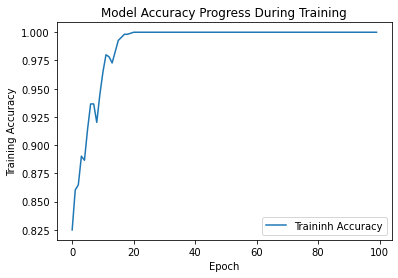

In [39]:
# plot the accuracy of training process
plt.plot(epochs_hist.history['accuracy'], label='Traininh Accuracy')
plt.gca().set(title='Model Accuracy Progress During Training',
             xlabel='Epoch',
             ylabel='Training Accuracy')
plt.legend();

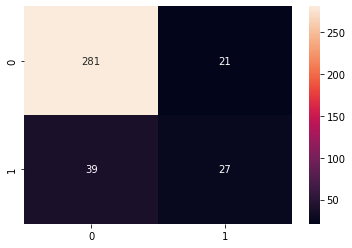

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       302
           1       0.56      0.41      0.47        66

    accuracy                           0.84       368
   macro avg       0.72      0.67      0.69       368
weighted avg       0.82      0.84      0.83       368



In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))